# **Assignment 2: Content Analysis and Regression**

For this assignment, you need to test a hypothesis using multiple linear regression. Before doing that, you also need to use computational content analysis and NLP techniques to create new variables that you will use as a predictor in the regression model.

##**Research Background**##

According to Chatman (1980), characters are constructs within abstracted narratives, described through networks of personality traits (e.g., Sarrasine is feminine, Othello is jealous, Roland Deschain is brave). Docherty characterizes the process of depicting and interpreting characters in literature as 'characterization' (cited by Bennett and Royle, 2017). Reaske (1996) identifies several devices of characterization, including character appearance, asides and soliloquies, dialogue, hidden narration, language, and actions performed. Characterization is crucial in narrative because it allows readers to relate to characters and feel emotionally engaged in the story (Cohen, 2001). providing information on personalities and behaviors for gender representation analysis in fiction.

For this assignment, you'll work with a corpus of the genre Real Person Fiction (RPF), where characters are characterized by blending real-life traits with fans' interpretations and reimagination, reflecting societal and cultural trends.

On the online fanfiction platform AO3, fanfictions about the Korean boy band BTS represent the largest fandom, surpassing even the Marvel Universe and Harry Potter franchises. Research into the global popularity of the Korean Wave (*Hallyu*) has highlighted the concept of "manufactured versatile masculinity" exhibited by male K-pop idols, a blend of softer, more effeminate appearances or behaviors with traditional forms of hegemonic masculinity, described by scholars such as Jung (2011), Kuo et al. (2020), Kwon (2019), and Oh (2015). Oh (2015) terms this "liminal masculinity," with androgynous K-pop male idols crossing gender lines.

**Aim:**

This assignment aims to analyze the impact of soft masculinity on K-pop fanfiction's success using a corpus of 100 BTS fanfictions.

**Data:**

We will utilize a dataset from the GOLEM project, comprising 100 BTS-related fanfictions, including story ID, publication year, word count, kudos, comments, and story content in English (1,000 to 1,200 words).

**Methods:**
- operationalize the concept of 'soft masculinity' to make it measurable
- use regression analysis to test a hypothesis

In [ ]:
# Load and check the dataset
import pandas as pd

df = pd.read_csv('BTS_short_100.csv', encoding="UTF-8")
df.head()

Have you noticed something odd in the first five lines of this dataset?

There are some duplicates.

So first we need to do some data cleaning, checking how many rows are duplicated and deleting the duplicates.


In [ ]:
# Get the number of unique rows
unique_story_ids = df['story_id'].nunique()

# Print the result
print(f"The number of unique 'story_id' values is: {unique_story_ids}")

In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()

df.head()

In [ ]:
# Let's check how many rows there are now
df.shape[0]

##**Research Design**##
The steps of this research involve formulating a hypothesis, selecting `kudos` as a proxy for the success of a story -- the dependent variable (Y) -- and calculating a masculinity score to be used as the independent variable (x1). We will also use additional variables that are also likely to have an effect on the success of a story: `publication_year` (x2) - because AO3 user base has grown in time and more recent stories are more likely to receive more kudos simply becasue there are more readers on the platform - and lexical richness (x3) - because it's plausible that a story with a richer vocabulary also has a better style and, therefore, it's liked more by readers.

Note that we don't have variables for `masculinity_score` and `lexical_richness` yet, so we need to calculate them from the text of the stories.

The hypothesis states:

H1: Low levels of masculinity in male characters positively affects fanfiction success when controlling for publication year and lexical richness.

**H0: What is the null hypothesis?**

# H0 (answer in words):
There is no apparent relationship between levels of masculinity in male characters and the success of fanfiction, when controlling for publication year and lexical richness.

##**Compute Masculinity Score**##

To calculate a sterotypical masculinity score, we can refer to older theories of perceived gender identity that probably define gender roles in a stereotypical way. an example of this is the Bem Sex-Role Inventory (BSRI) by Dr. Sandra Lipzits Bem (1974), which classifies personality traits into masculine, feminine, and androgynous.

Bem divides personal traits into 60 traits: 20 masculine traits, 20 feminine traits and 20 neutral traits (see figure below).


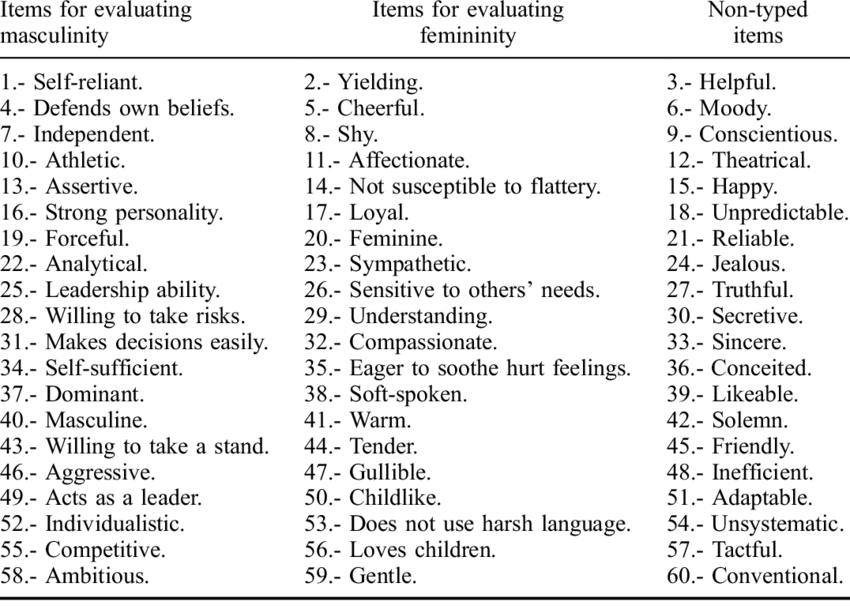

The above list shows that, despite recent discussions about masculinity, femininity, and gender roles have become more diversified, traditional definitions such as those provided by the Bem Sex-Role Inventory (BSRI) can be useful to detect gender stereotypes. Within the definitions of masculinity and femininity outlined by the BSRI, we observe a clear power imbalance: masculinity is associated with dominance (e.g., assertive, strong personality, forceful, leadership ability, dominant, aggressive, ambitious), while femininity leans towards submissiveness (e.g., yielding, understanding, tender). Therefore, we can consider employing the power-agent frames designed by Sap et al. to compute a power score for the male characters in the fanfiction stories. Lower masculinity scores can be plausibly associated with a representation of 'soft masculinity' in relation to a character.

###**Riveter**###

In the W5 lab, we have already gained preliminary experience with the Riveter pipeline.

In this section, we will use utilize the Riveter pipeline with Sap's power-agent frames to calculate the `masculinity_score` for identifiable agents in the text. Since we are interested only in the masculinity of male characters, we will use regular expressions to identify male pronouns (he, him, himself) and calculate their corresponding `masculinity_score`. This score will be added to the df as a new column.


In [ ]:
# Set up everything you need to use Riveter, following the notebook we used in W5 lab
# No need to put the code here, as long as it's working
# We assume that you have installed all the required packages, either locally or on Colab

Now we have prepared all the dependencies needed.

In [ ]:
from collections import defaultdict
import os
import pandas as pd
import random
from riveter import Riveter # if the notebook is not in the /riveter folder, this will throw an error

import seaborn as sns
import matplotlib.pyplot as plt

**Prepare the corpus**:

First, we can try to initialize two lists to store `story_content` and `story_id`, but this will casue the problem below:

`Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512).`

This is a limit of the language model (BERT) used by Riveter. We need to split the file into smaller chunks in order for it to be processed correctly. The example in the original Riveter notebook where they load *Pride and Prejudice* shows how we can do this. The code is also provided here below.




In [ ]:
def split_text_into_segments(text, max_length=512):
    """
    Segment the text so that each segment contains a maximum of max length tokens.
    """
    segments = []
    current_segment = []
    for word in text.split():
        if len(current_segment) + len(word.split()) <= max_length:
            current_segment.append(word)
        else:
            segments.append(' '.join(current_segment))
            current_segment = [word]
    if current_segment:
        segments.append(' '.join(current_segment))
    return segments

Let's first initialize Riveter with the lexicon that we are going to use:

In [ ]:
# Q0 (code): Load lexicon 'power' and create an empty dictionary called 'scores_dict'
riveter = Riveter()
riveter.load_sap_lexicon('power')

scores_dict = {}

Now we can apply the splitting function we defined above and then use Riveter on our corpus. To do this, we need to create a loop that iterates through all the rows in the dataframe and compute scores for each story.

**Q1. Train Riveter to assign scores to text based on male pronouns**

In [53]:
from tqdm import tqdm # used to display a progress bar when executing code

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing stories"):
    story_id = row['story_id']
    story_content = row['story_content']
   
    # apply the splitting function:
    segments = split_text_into_segments(story_content)
    text_ids = [f"{story_id}_{i}" for i in range(len(segments))]

    # Q1 (code): train riveter specifying 'persona_patterns_dict= ' to assign scores only based on male pronouns
    # write code below:
    riveter = Riveter()
    riveter.load_sap_lexicon('power')
    riveter.train(segments,text_ids,
             num_bootstraps=20,
             persona_patterns_dict={'masculine': r'^he$|^him$|^himself$'})# Trains the Riveter model，useing 20 bootstrap samples  during the training process 
    
    # store the computed scores in a dictionary
    persona_score_dict = riveter.get_score_totals()
    masculine_score = persona_score_dict.get('masculine', 0)

    # get a feedback about the computed scores while the code is running
    print(f"Story ID: {story_id}, Masculine Power Score: {masculine_score}")

    # store the score of each story in the same dictionary so that we can then add it to the dataframe
    scores_dict[story_id] = masculine_score

# add the dictionary of scores to the dataframe
df['masculine_power_score'] = df['story_id'].map(scores_dict)

Processing stories:   1%|▎                       | 1/90 [00:03<05:22,  3.63s/it]

2024-05-30 08:43:04 Complete!
Story ID: 4706144, Masculine Power Score: 0.08445887445887446



Processing stories:   2%|▌                       | 2/90 [00:07<05:18,  3.62s/it]

2024-05-30 08:43:07 Complete!
Story ID: 4752980, Masculine Power Score: 0.26321607192647256



Processing stories:   3%|▊                       | 3/90 [00:10<04:55,  3.39s/it]

2024-05-30 08:43:10 Complete!
Story ID: 4621698, Masculine Power Score: 0.6323809523809525



Processing stories:   4%|█                       | 4/90 [00:13<04:58,  3.47s/it]

2024-05-30 08:43:14 Complete!
Story ID: 3651108, Masculine Power Score: 0.11667214205577378



Processing stories:   6%|█▎                      | 5/90 [00:17<05:01,  3.55s/it]

2024-05-30 08:43:18 Complete!
Story ID: 5282729, Masculine Power Score: 0.20657898091208052



Processing stories:   7%|█▌                      | 6/90 [00:21<05:07,  3.66s/it]

2024-05-30 08:43:22 Complete!
Story ID: 5533886, Masculine Power Score: -0.00993748722240859



Processing stories:   8%|█▊                      | 7/90 [00:25<05:07,  3.71s/it]

2024-05-30 08:43:25 Complete!
Story ID: 4547622, Masculine Power Score: 0.014101350760622489



Processing stories:   9%|██▏                     | 8/90 [00:28<04:51,  3.55s/it]

2024-05-30 08:43:29 Complete!
Story ID: 16177508, Masculine Power Score: 0.1823645620745035



Processing stories:  10%|██▍                     | 9/90 [00:31<04:44,  3.52s/it]

2024-05-30 08:43:32 Complete!
Story ID: 15745185, Masculine Power Score: -0.10436722661235709



Processing stories:  11%|██▌                    | 10/90 [00:35<04:42,  3.53s/it]

2024-05-30 08:43:36 Complete!
Story ID: 15654528, Masculine Power Score: 0.24198141016497882



Processing stories:  12%|██▊                    | 11/90 [00:38<04:34,  3.47s/it]

2024-05-30 08:43:39 Complete!
Story ID: 7448155, Masculine Power Score: 0.32241967897969065



Processing stories:  13%|███                    | 12/90 [00:42<04:37,  3.56s/it]

2024-05-30 08:43:43 Complete!
Story ID: 4983847, Masculine Power Score: 0.0877750318130065



Processing stories:  14%|███▎                   | 13/90 [00:46<04:37,  3.60s/it]

2024-05-30 08:43:46 Complete!
Story ID: 3313118, Masculine Power Score: -0.21841414925654062



Processing stories:  16%|███▌                   | 14/90 [00:49<04:34,  3.62s/it]

2024-05-30 08:43:50 Complete!
Story ID: 3290390, Masculine Power Score: -0.07428571428571427



Processing stories:  17%|███▊                   | 15/90 [00:54<04:44,  3.80s/it]

2024-05-30 08:43:54 Complete!
Story ID: 36435301, Masculine Power Score: 0.04893359959149433



Processing stories:  18%|████                   | 16/90 [00:58<04:41,  3.80s/it]

2024-05-30 08:43:58 Complete!
Story ID: 36575491, Masculine Power Score: 0.2949497236338486



Processing stories:  19%|████▎                  | 17/90 [01:01<04:38,  3.81s/it]

2024-05-30 08:44:02 Complete!
Story ID: 35225224, Masculine Power Score: 0.238876303178573



Processing stories:  20%|████▌                  | 18/90 [01:05<04:36,  3.84s/it]

2024-05-30 08:44:06 Complete!
Story ID: 4594527, Masculine Power Score: 0.22765956265956264



Processing stories:  21%|████▊                  | 19/90 [01:09<04:26,  3.75s/it]

2024-05-30 08:44:09 Complete!
Story ID: 5485625, Masculine Power Score: 0.10504219918013022



Processing stories:  22%|█████                  | 20/90 [01:13<04:27,  3.82s/it]

2024-05-30 08:44:13 Complete!
Story ID: 36408319, Masculine Power Score: 0.1514265074450833



Processing stories:  23%|█████▎                 | 21/90 [01:17<04:42,  4.09s/it]

2024-05-30 08:44:18 Complete!
Story ID: 35762659, Masculine Power Score: 0.20546423712585712



Processing stories:  24%|█████▌                 | 22/90 [01:22<04:45,  4.20s/it]

2024-05-30 08:44:23 Complete!
Story ID: 35603194, Masculine Power Score: 0.392486799553475



Processing stories:  26%|█████▉                 | 23/90 [01:26<04:45,  4.26s/it]

2024-05-30 08:44:27 Complete!
Story ID: 35344306, Masculine Power Score: 0.1395036391433006



Processing stories:  27%|██████▏                | 24/90 [01:30<04:31,  4.12s/it]

2024-05-30 08:44:31 Complete!
Story ID: 36695155, Masculine Power Score: 0.09722222222222222



Processing stories:  28%|██████▍                | 25/90 [01:35<04:34,  4.22s/it]

2024-05-30 08:44:35 Complete!
Story ID: 36064474, Masculine Power Score: 0.10010049653220847



Processing stories:  29%|██████▋                | 26/90 [01:39<04:34,  4.29s/it]

2024-05-30 08:44:40 Complete!
Story ID: 36024820, Masculine Power Score: 0.09691230639506501



Processing stories:  30%|██████▉                | 27/90 [01:44<04:47,  4.56s/it]

2024-05-30 08:44:45 Complete!
Story ID: 35182330, Masculine Power Score: 0.0621926818266428



Processing stories:  31%|███████▏               | 28/90 [01:49<04:48,  4.65s/it]

2024-05-30 08:44:50 Complete!
Story ID: 36567496, Masculine Power Score: 0.20367720921737545



Processing stories:  32%|███████▍               | 29/90 [01:54<04:44,  4.66s/it]

2024-05-30 08:44:54 Complete!
Story ID: 35560330, Masculine Power Score: 0.19543025043873938



Processing stories:  33%|███████▋               | 30/90 [01:59<04:44,  4.75s/it]

2024-05-30 08:44:59 Complete!
Story ID: 35877496, Masculine Power Score: 0.14011873254048549



Processing stories:  34%|███████▉               | 31/90 [02:03<04:36,  4.69s/it]

2024-05-30 08:45:04 Complete!
Story ID: 35957410, Masculine Power Score: 0.28311004452538696



Processing stories:  36%|████████▏              | 32/90 [02:08<04:29,  4.64s/it]

2024-05-30 08:45:08 Complete!
Story ID: 30947654, Masculine Power Score: -0.004222495894909686



Processing stories:  37%|████████▍              | 33/90 [02:12<04:23,  4.62s/it]

2024-05-30 08:45:13 Complete!
Story ID: 36332707, Masculine Power Score: -0.18882906122927157



Processing stories:  38%|████████▋              | 34/90 [02:17<04:24,  4.72s/it]

2024-05-30 08:45:18 Complete!
Story ID: 35967940, Masculine Power Score: 0.16612462490517



Processing stories:  39%|████████▉              | 35/90 [02:22<04:19,  4.72s/it]

2024-05-30 08:45:23 Complete!
Story ID: 35001073, Masculine Power Score: -0.016315628815628817



Processing stories:  40%|█████████▏             | 36/90 [02:27<04:16,  4.74s/it]

2024-05-30 08:45:28 Complete!
Story ID: 35138911, Masculine Power Score: 0.1373050647018437



Processing stories:  41%|█████████▍             | 37/90 [02:31<03:58,  4.49s/it]

2024-05-30 08:45:31 Complete!
Story ID: 35280397, Masculine Power Score: 0.2586537081339713



Processing stories:  42%|█████████▋             | 38/90 [02:36<04:00,  4.63s/it]

2024-05-30 08:45:36 Complete!
Story ID: 36049939, Masculine Power Score: 0.3188279884735441



Processing stories:  43%|█████████▉             | 39/90 [02:41<04:00,  4.72s/it]

2024-05-30 08:45:41 Complete!
Story ID: 34995673, Masculine Power Score: 0.17326153524167692



Processing stories:  44%|██████████▏            | 40/90 [02:46<04:04,  4.89s/it]

2024-05-30 08:45:47 Complete!
Story ID: 33477346, Masculine Power Score: 0.44366501402483555



Processing stories:  46%|██████████▍            | 41/90 [02:50<03:50,  4.71s/it]

2024-05-30 08:45:51 Complete!
Story ID: 36840832, Masculine Power Score: -0.26541275610354553



Processing stories:  47%|██████████▋            | 42/90 [02:54<03:37,  4.52s/it]

2024-05-30 08:45:55 Complete!
Story ID: 30896276, Masculine Power Score: 0.1394736842105263



Processing stories:  48%|██████████▉            | 43/90 [02:58<03:27,  4.41s/it]

2024-05-30 08:45:59 Complete!
Story ID: 37363471, Masculine Power Score: 0.42077922077922075



Processing stories:  49%|███████████▏           | 44/90 [03:03<03:20,  4.35s/it]

2024-05-30 08:46:03 Complete!
Story ID: 36984901, Masculine Power Score: 0.10716464209531915



Processing stories:  50%|███████████▌           | 45/90 [03:07<03:14,  4.32s/it]

2024-05-30 08:46:08 Complete!
Story ID: 33353644, Masculine Power Score: -0.07061646732845402



Processing stories:  51%|███████████▊           | 46/90 [03:11<03:09,  4.32s/it]

2024-05-30 08:46:12 Complete!
Story ID: 37002835, Masculine Power Score: -0.14761655011655012



Processing stories:  52%|████████████           | 47/90 [03:15<03:02,  4.24s/it]

2024-05-30 08:46:16 Complete!
Story ID: 5630824, Masculine Power Score: 0.3013723452319943



Processing stories:  53%|████████████▎          | 48/90 [03:20<02:59,  4.28s/it]

2024-05-30 08:46:20 Complete!
Story ID: 10053617, Masculine Power Score: 0.2427083333333333



Processing stories:  54%|████████████▌          | 49/90 [03:24<02:55,  4.27s/it]

2024-05-30 08:46:25 Complete!
Story ID: 1572659, Masculine Power Score: 0.23330239613327847



Processing stories:  56%|████████████▊          | 50/90 [03:29<02:54,  4.36s/it]

2024-05-30 08:46:29 Complete!
Story ID: 7450573, Masculine Power Score: 0.23804945054945054



Processing stories:  57%|█████████████          | 51/90 [03:33<02:51,  4.40s/it]

2024-05-30 08:46:34 Complete!
Story ID: 6918676, Masculine Power Score: 0.016801056783881767



Processing stories:  58%|█████████████▎         | 52/90 [03:38<02:55,  4.61s/it]

2024-05-30 08:46:39 Complete!
Story ID: 6075402, Masculine Power Score: 0.3636270347050212



Processing stories:  59%|█████████████▌         | 53/90 [03:43<02:52,  4.66s/it]

2024-05-30 08:46:44 Complete!
Story ID: 11101779, Masculine Power Score: 0.33815018315018314



Processing stories:  60%|█████████████▊         | 54/90 [03:48<02:50,  4.74s/it]

2024-05-30 08:46:48 Complete!
Story ID: 11321331, Masculine Power Score: 0.09671530216320806



Processing stories:  61%|██████████████         | 55/90 [03:52<02:40,  4.57s/it]

2024-05-30 08:46:53 Complete!
Story ID: 12284853, Masculine Power Score: 0.03952752561448214



Processing stories:  62%|██████████████▎        | 56/90 [03:56<02:34,  4.54s/it]

2024-05-30 08:46:57 Complete!
Story ID: 12282003, Masculine Power Score: 0.1296084413933384



Processing stories:  63%|██████████████▌        | 57/90 [04:01<02:25,  4.40s/it]

2024-05-30 08:47:01 Complete!
Story ID: 7613533, Masculine Power Score: 0



Processing stories:  64%|██████████████▊        | 58/90 [04:05<02:18,  4.33s/it]

2024-05-30 08:47:05 Complete!
Story ID: 4228053, Masculine Power Score: 0.21171909979969367



Processing stories:  66%|███████████████        | 59/90 [04:09<02:17,  4.44s/it]

2024-05-30 08:47:10 Complete!
Story ID: 12127317, Masculine Power Score: 0.12711815982884395



Processing stories:  67%|███████████████▎       | 60/90 [04:14<02:10,  4.35s/it]

2024-05-30 08:47:14 Complete!
Story ID: 12010134, Masculine Power Score: 0.27470792768948643



Processing stories:  68%|███████████████▌       | 61/90 [04:18<02:10,  4.50s/it]

2024-05-30 08:47:19 Complete!
Story ID: 11510919, Masculine Power Score: 0.45434343434343427



Processing stories:  69%|███████████████▊       | 62/90 [04:23<02:06,  4.51s/it]

2024-05-30 08:47:24 Complete!
Story ID: 8145802, Masculine Power Score: 0.2864764587733628



Processing stories:  70%|████████████████       | 63/90 [04:27<02:00,  4.46s/it]

2024-05-30 08:47:28 Complete!
Story ID: 6637942, Masculine Power Score: -0.1665080690456961



Processing stories:  71%|████████████████▎      | 64/90 [04:31<01:54,  4.39s/it]

2024-05-30 08:47:32 Complete!
Story ID: 7427905, Masculine Power Score: -0.019674019607843138



Processing stories:  72%|████████████████▌      | 65/90 [04:36<01:48,  4.36s/it]

2024-05-30 08:47:36 Complete!
Story ID: 3893857, Masculine Power Score: 0.11179298337006707



Processing stories:  73%|████████████████▊      | 66/90 [04:40<01:44,  4.35s/it]

2024-05-30 08:47:41 Complete!
Story ID: 33040258, Masculine Power Score: 0.16834967320261435



Processing stories:  74%|█████████████████      | 67/90 [04:45<01:42,  4.47s/it]

2024-05-30 08:47:45 Complete!
Story ID: 33858850, Masculine Power Score: -0.14517321976992825



Processing stories:  76%|█████████████████▍     | 68/90 [04:49<01:39,  4.50s/it]

2024-05-30 08:47:50 Complete!
Story ID: 2775776, Masculine Power Score: 0.25604707704637575



Processing stories:  77%|█████████████████▋     | 69/90 [04:54<01:34,  4.49s/it]

2024-05-30 08:47:55 Complete!
Story ID: 3197963, Masculine Power Score: 0.3559615384615385



Processing stories:  78%|█████████████████▉     | 70/90 [04:58<01:28,  4.43s/it]

2024-05-30 08:47:59 Complete!
Story ID: 12395199, Masculine Power Score: 0.13994993005445966



Processing stories:  79%|██████████████████▏    | 71/90 [05:02<01:21,  4.30s/it]

2024-05-30 08:48:03 Complete!
Story ID: 10934010, Masculine Power Score: 0.29937728937728936



Processing stories:  80%|██████████████████▍    | 72/90 [05:06<01:15,  4.19s/it]

2024-05-30 08:48:07 Complete!
Story ID: 12301116, Masculine Power Score: 0.04326651500577356



Processing stories:  81%|██████████████████▋    | 73/90 [05:10<01:12,  4.24s/it]

2024-05-30 08:48:11 Complete!
Story ID: 12706317, Masculine Power Score: -0.09652486691954609



Processing stories:  82%|██████████████████▉    | 74/90 [05:15<01:11,  4.47s/it]

2024-05-30 08:48:16 Complete!
Story ID: 11499468, Masculine Power Score: -0.11486689963513026



Processing stories:  83%|███████████████████▏   | 75/90 [05:20<01:05,  4.35s/it]

2024-05-30 08:48:20 Complete!
Story ID: 12184146, Masculine Power Score: 0.3187489422480934



Processing stories:  84%|███████████████████▍   | 76/90 [05:24<01:00,  4.32s/it]

2024-05-30 08:48:24 Complete!
Story ID: 12201333, Masculine Power Score: 0.11057928257509901



Processing stories:  86%|███████████████████▋   | 77/90 [05:29<00:58,  4.50s/it]

2024-05-30 08:48:29 Complete!
Story ID: 11496030, Masculine Power Score: 0.009533194957089621



Processing stories:  87%|███████████████████▉   | 78/90 [05:33<00:54,  4.50s/it]

2024-05-30 08:48:34 Complete!
Story ID: 11510277, Masculine Power Score: 0.14596467382007958



Processing stories:  88%|████████████████████▏  | 79/90 [05:38<00:50,  4.60s/it]

2024-05-30 08:48:39 Complete!
Story ID: 10772274, Masculine Power Score: 0.4032744556657599



Processing stories:  89%|████████████████████▍  | 80/90 [05:43<00:45,  4.57s/it]

2024-05-30 08:48:43 Complete!
Story ID: 12646050, Masculine Power Score: 0.06216083323281466



Processing stories:  90%|████████████████████▋  | 81/90 [05:47<00:40,  4.50s/it]

2024-05-30 08:48:48 Complete!
Story ID: 11161479, Masculine Power Score: -0.020946916828359786



Processing stories:  91%|████████████████████▉  | 82/90 [05:51<00:35,  4.45s/it]

2024-05-30 08:48:52 Complete!
Story ID: 12069936, Masculine Power Score: 0.1543623931377348



Processing stories:  92%|█████████████████████▏ | 83/90 [05:56<00:31,  4.45s/it]

2024-05-30 08:48:56 Complete!
Story ID: 12285972, Masculine Power Score: 0.39942165792607964



Processing stories:  93%|█████████████████████▍ | 84/90 [06:00<00:26,  4.37s/it]

2024-05-30 08:49:00 Complete!
Story ID: 12372702, Masculine Power Score: 0.052280764568061765



Processing stories:  94%|█████████████████████▋ | 85/90 [06:04<00:21,  4.38s/it]

2024-05-30 08:49:05 Complete!
Story ID: 12610496, Masculine Power Score: 0.09461717765302176



Processing stories:  96%|█████████████████████▉ | 86/90 [06:09<00:17,  4.42s/it]

2024-05-30 08:49:09 Complete!
Story ID: 10970472, Masculine Power Score: 0.1613904350400241



Processing stories:  97%|██████████████████████▏| 87/90 [06:13<00:12,  4.27s/it]

2024-05-30 08:49:13 Complete!
Story ID: 12084552, Masculine Power Score: 0.306810305786914



Processing stories:  98%|██████████████████████▍| 88/90 [06:18<00:08,  4.47s/it]

2024-05-30 08:49:18 Complete!
Story ID: 12727119, Masculine Power Score: -0.1063149696785091



Processing stories:  99%|██████████████████████▋| 89/90 [06:22<00:04,  4.37s/it]

2024-05-30 08:49:22 Complete!
Story ID: 11962824, Masculine Power Score: 0.0



Processing stories: 100%|███████████████████████| 90/90 [06:26<00:00,  4.29s/it]

2024-05-30 08:49:27 Complete!
Story ID: 10859508, Masculine Power Score: 0.2825444624840062


**Q2. Print a sample of the dataframe to check whether the `masculine_power_score` has been added correctly**

In [54]:
# Q2 (code)
df.head()


,story_id,published_year,words,kudos,comments,story_content,masculine_power_score
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...,0.084459
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...,0.263216
3,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...,0.632381
5,3651108,2015,1174,339.0,6.0,Purple Gel Pens\n\nAuthor's Note:\n\nwtf is th...,0.116672
7,5282729,2015,1173,17.0,NaN,"Unspoken Words\n\nYou come back into the flat,...",0.206579


In [ ]:
# If you use google colab, it's better to save this result locally in case the connection breaks and then you lose the result.
df.to_csv('/content/df.csv', index=False)

##**Compute Lexical Richness Score**##

'Lexical richness' refers to the range and variety of vocabulary deployed in a text by a speaker/writer. 'Lexical richness' is a term used interchangeably with 'lexical diversity', 'lexical variation', 'lexical density', and 'vocabulary richnes', and it's measured by a wide variety of indices. Uses include (but are not limited to) measuring writing quality, vocabulary knowledge, speaker competence, and socioeconomic status.


The type-token ratio (TTR) is a simple measure of lexical diversity within a text. It is calculated by dividing the number of unique words (types) by the total number of words (tokens) in the given text. A higher TTR indicates a greater variety of vocabulary, suggesting richer lexical content. Conversely, a lower TTR suggests more repetitive use of vocabulary. TTR is often used to assess the lexical complexity of written or spoken material.

Here we use the package `lexicalrichness` (https://pypi.org/project/lexicalrichness/) to compute type-token ratio (TTR) for each story as a control on their language quality.

In [6]:
!pip install lexicalrichness

In [55]:
from lexicalrichness import LexicalRichness

# Define a function that calculates the lexical richness of the text
def calculate_lexical_richness(text):
    # Create a LexicalRichness object for the text
    lex = LexicalRichness(text)
    # Compute type-token ratio (TTR)
    return lex.ttr  # Returns the type-token ratio

# Apply the function to the 'story content' column in the DataFrame
df['lexical_richness'] = df['story_content'].apply(calculate_lexical_richness)

# Display the DataFrame with the new 'lexical_richness' column
df.head()

,story_id,published_year,words,kudos,comments,story_content,masculine_power_score,lexical_richness
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...,0.084459,0.428571
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...,0.263216,0.400665
3,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...,0.632381,0.428986
5,3651108,2015,1174,339.0,6.0,Purple Gel Pens\n\nAuthor's Note:\n\nwtf is th...,0.116672,0.412295
7,5282729,2015,1173,17.0,NaN,"Unspoken Words\n\nYou come back into the flat,...",0.206579,0.376110


Now that we have both the two new variables added to the dataframe, we have all we need to test our hypothesis with linear regression.

##**Regressions**##


**Methodology**

- Multiple Linear Regression: Perform a regression analysis with `kudos` as the dependent variable and `masculine_power_score`, `published_year`, and `words` as independent variables.
- Residual Analysis: Conduct normality and homoscedasticity tests on the residuals to validate the assumptions of linear regression.
- Model Evaluation: Assess the model using adjusted R-squared, F-test, and t-tests for individual coefficients.
- Multicollinearity Check: Calculate the Variance Inflation Factor (VIF) for the independent variables to detect possible multicollinearity.

**Q3. Check the data distribution and handle missing values**


/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

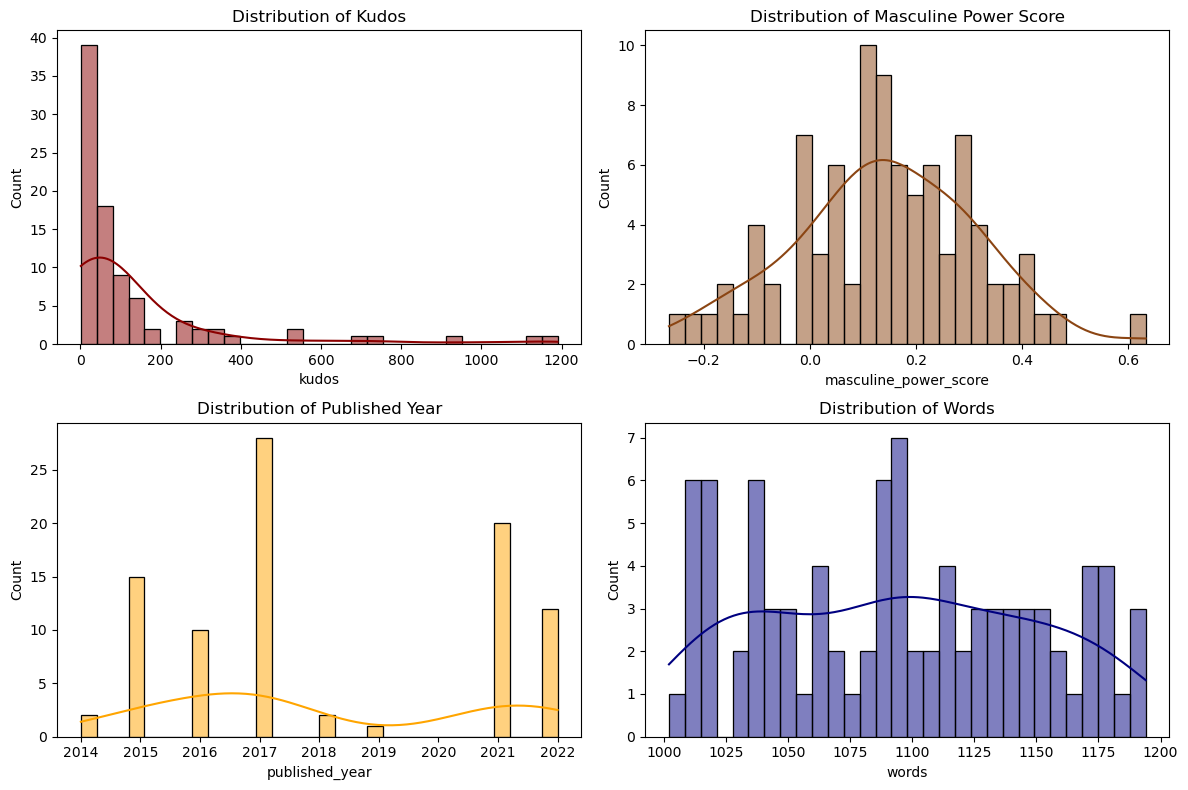

In [58]:
# Q3a (code): Check data distribution

# Importing the matplotlib library for basic plotting
import matplotlib.pyplot as plt
# Importing the seaborn library for statistical data visualization
import seaborn as sns

# Plot histograms for each variable
plt.figure(figsize=(12, 8))  # Set the size of the plot

# Plot for 'kudos' distribution
plt.subplot(2, 2, 1)  # Create subplot for the first variable
sns.histplot(df['kudos'], kde=True, color='darkred', bins=30)  # Plot histogram with KDE and specified color
plt.title('Distribution of Kudos')  # Set title for the plot

# Plot for 'masculine_power_score' distribution
plt.subplot(2, 2, 2)  # Create subplot for the second variable
sns.histplot(df['masculine_power_score'], kde=True, color='saddlebrown', bins=30)  # Plot histogram with KDE and specified color
plt.title('Distribution of Masculine Power Score')  # Set title for the plot

# Plot for 'published_year' distribution
plt.subplot(2, 2, 3)  # Create subplot for the third variable
sns.histplot(df['published_year'], kde=True, color='orange', bins=30)  # Plot histogram with KDE and specified color
plt.title('Distribution of Published Year')  # Set title for the plot

# Plot for 'words' distribution
plt.subplot(2, 2, 4)  # Create subplot for the fourth variable
sns.histplot(df['words'], kde=True, color='navy', bins=30)  # Plot histogram with KDE and specified color
plt.title('Distribution of Words')  # Set title for the plot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot





In [59]:
# Q3b (code): compute some descriptive statistics
# Compute descriptive statistics 
descriptive_stats = df[['kudos', 'masculine_power_score', 'published_year', 'words']].describe()

# Print the descriptive statistics
print("Descriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
             kudos  masculine_power_score  published_year        words
count    89.000000              90.000000       90.000000    90.000000
mean    135.393258               0.141788     2018.088889  1094.344444
std     229.972311               0.168239        2.612177    55.327048
min       1.000000              -0.265413     2014.000000  1002.000000
25%      20.000000               0.040462     2016.000000  1042.250000
50%      54.000000               0.139727     2017.000000  1095.000000
75%     122.000000               0.258002     2021.000000  1141.750000
max    1190.000000               0.632381     2022.000000  1194.000000


In [60]:
# Q3c (code): Check for any missing values
# Check for missing values
missing_values = df.isnull().sum()

# Print the count of missing values for each column
print("Missing Values:")
print(missing_values)


Missing Values:
story_id                  0
published_year            0
words                     0
kudos                     1
comments                 25
story_content             0
masculine_power_score     0
lexical_richness          0
dtype: int64


In [61]:
# Q3d (code): replace all the NA values with zeros and check again Q3c
# Replace NA values with zeros
df.fillna(0, inplace=True)

# Check for missing values again
missing_values_after_fillna = df.isnull().sum()

# Print the count of missing values for each column after filling NA values with zeros
print("Missing Values after replacing with zeros:")
print(missing_values_after_fillna)


Missing Values after replacing with zeros:
story_id                 0
published_year           0
words                    0
kudos                    0
comments                 0
story_content            0
masculine_power_score    0
lexical_richness         0
dtype: int64


It's always important to visualize the data to inspect the distributions of values for the variables your interested in (do you remember the dinosaur data shown in class?).

**Q4. Create a scatterplot with `masculine_power_score` and `kudos`**

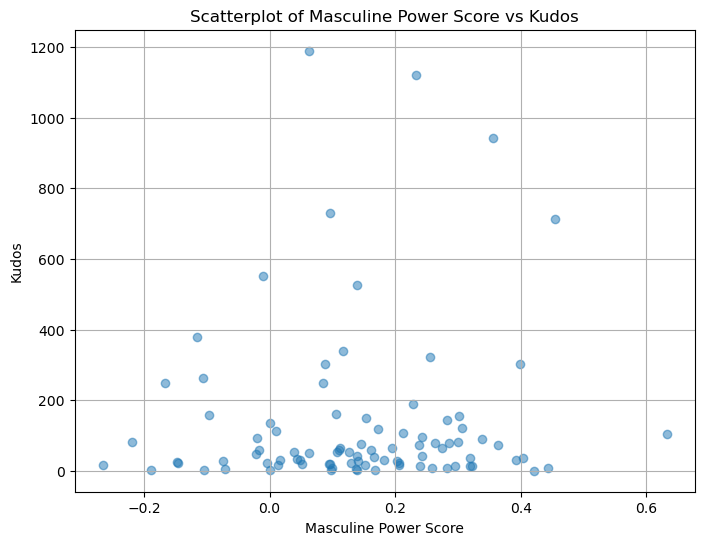

In [62]:
# Q4 (code): Create a scatterplot with masculine_power_score and kudos

# Import necessary library for plotting data and creating visualizations
import matplotlib.pyplot as plt

# Create a scatterplot with masculine_power_score and kudos
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.scatter(df['masculine_power_score'], df['kudos'], alpha=0.5)  # Scatter plot with specified alpha value for transparency
plt.title('Scatterplot of Masculine Power Score vs Kudos')  # Set title for the plot
plt.xlabel('Masculine Power Score')  # Set label for x-axis
plt.ylabel('Kudos')  # Set label for y-axis
plt.grid(True)  # Show grid
plt.show()  # Show the plot


**Q5. Multiple Regression and Analysis**

In [44]:
# Q5 (code): Do OLS Multiple Regression and print the regression result summary

# Importing the statsmodels library for statistical modeling and analysis
import statsmodels.api as sm

# Define the independent variables (X) and the dependent variable (y)
X = df[['masculine_power_score', 'published_year', 'words']]  # Independent variables
y = df['kudos']  # Dependent variable

# Add a constant to the independent variables (X) for the intercept term
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the regression results summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  kudos   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     5.638
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00142
Time:                        05:32:27   Log-Likelihood:                -608.20
No. Observations:                  90   AIC:                             1224.
Df Residuals:                      86   BIC:                             1234.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.968e+

**Q6. Interpret the results of the regression analysis**

In [ ]:
# Q6a (words): Interpret the R-squared and Adj. R-squared

The R-squared (coefficient of determination) and adjusted R-squared are measures of how well the independent variables explain the variation in the dependent variable.

R-squared (R²): In this regression analysis, the R-squared value is 0.164, which means that approximately 16.4% of the variation in the dependent variable (kudos) can be explained by the independent variables (masculine_power_score, published_year, and words). In other words, these independent variables collectively account for 16.4% of the variability observed in the kudos received.

Adjusted R-squared (Adj. R²): The adjusted R-squared value is 0.135. This adjusted value takes into account the number of independent variables in the model and provides a more accurate measure of the goodness of fit. It penalizes the R-squared for the number of independent variables included in the model. In this case, the adjusted R-squared is slightly lower than the R-squared, indicating that the inclusion of some independent variables may not significantly improve the model's explanatory power.

Overall, both R-squared and adjusted R-squared suggest that the independent variables have limited explanatory power in predicting the kudos received, as the majority of the variation in the dependent variable remains unexplained by the regression model.

In [ ]:
# Q6b (words): Interpret F-test result
The F-test is employed to examine if the overall regression model is statistically significant.The F-statistic is 5.638, and the associated p-value is 0.000142 in this analysis. The p-value is below the conventional significance level of 0.05, indicating that the regression model as a whole is statistically significant. Therefore, there is at least one of the independent variables, masculine_power_score, published_year, and words, has a significant effect on the kudos received. However, the F-test  tells us that at least one of them is, rather than specify which specific independent variables are significant,.

In conclusion, the F-test result suggests that the regression model is statistically significant, meaning that the independent variables collectively have a significant effect on the dependent variable, kudos.

In [ ]:
# Q6c (words): Interpret coefficients and t-test result

The constant term is 6.986e+04, representing the estimated kudos when all independent variables are zero.

The Masculine Power Score coefficient is 69.1521, suggesting that for every one-unit increase in this score, kudos increase units accordingly. However, its t-value (0.502) and p-value of 0.617 indicates it's not statistically significant.

The Published Year coefficient is -34.2960, indicating that for every one-year increase in the publication year, kudos decrease by approximately 34.296 units. Its t-value (-3.951)  and p-value (0.000)suggests statistical significance.

The Words coefficient is -0.3092, implying that for every one-unit increase in word count, kudos decrease by about 0.3219 units. However, its t-value (-0.757)  and p-value (0.451)suggests it's not statistically significant.

In regression analysis, each coefficient represents the estimated change in the dependent variable (kudos) associated with a one-unit change in the corresponding independent variable, while holding all other variables constant. Therefore, the analysis suggests that only the Published Year variable significantly predicts kudos, while Masculine Power Score and Words variables do not.

Based on the OLS regression results provided, here is an example analysis:

The model's R-squared value of 0.162 indicates that approximately 16.2% of the variability in the kudos can be explained by the model. While this suggests that the model explains a portion of the variability, there remains a significant amount unaccounted for, which might be explained by factors not included in the model.

The adjusted R-squared value of 0.133 takes into account the number of predictors in the model and the number of observations, showing a slight decrease from the R-squared value, which is normal as it adjusts for the number of terms in the model.

Looking at the coefficients:

const (6.995e+04): The constant term is significantly different from zero, which may represent the base number of kudos when all other variables are held at zero.
masculine_power_score (59.7927): This variable is not statistically significant (p-value 0.668) with a wide confidence interval, suggesting that the masculine power score does not significantly impact the number of kudos in the given dataset.
lexical_richness (390.3633): Similar to the masculine power score, lexical richness does not appear to significantly affect the number of kudos (p-value 0.524).
published_year (-34.6801): This is the only variable with a statistically significant coefficient (p-value < 0.001), indicating that more recent stories tend to have fewer kudos.
The large F-statistic (5.561) and its associated low probability (0.00155) suggest that the overall model is statistically significant compared to a model without any predictors.

**Q7: Residual Analysis**

Normality Test, Homoscedasticity Test

In [56]:
# Q7a (code): Calculate residuals and do a Shapiro-Wilk Test

# Importing the stats module from scipy library
import scipy.stats as stats 

# Calculate residuals
residuals = model.resid

from scipy import stats

# Extracting independent variables and adding a constant for the intercept
X = df[['masculine_power_score', 'published_year', 'words']]
X = sm.add_constant(X)

# Extracting the dependent variable
y = df['kudos']

# Creating a linear regression model
model = sm.OLS(y, X)

# Fitting the model
results = model.fit()

# Calculating residuals
residuals = results.resid

# Performing Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_test_p_value = stats.shapiro(residuals)

# Printing the results of the Shapiro-Wilk test
print("Shapiro-Wilk Test:")
print("Test Statistic:", shapiro_test_statistic)
print("p-value:", shapiro_test_p_value)
shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals) # Shapiro-Wilk test for normality on residuals

print("Shapiro-Wilk Test for Normality:")
print(f"Test Statistic: {shapiro_test_statistic}") # Print the test statistic
print(f"P-value: {shapiro_p_value}") # Print the p-value


Shapiro-Wilk Test:
Test Statistic: 0.6971123218536377
p-value: 2.4782354987595845e-12
Shapiro-Wilk Test for Normality:
Test Statistic: 0.6971123218536377
P-value: 2.4782354987595845e-12


In [ ]:
# Q7b (words): Write your analysis for the Normality Test there:
The Shapiro-Wilk test for normality resulted in a test statistic of 0.697 and a p-value of approximately 2.48e-12.

The low p-value is smaller than the typical significance level of 0.05, rejecting the null hypothesis that the residuals follow a normal distribution.  Therefore, residuals do not adhere to a normal distribution based on the result.However, the assumption of violating the normality in the linear regression model could impact the validity of statistical inferences. Investigation or alternative modeling approaches may be necessary for further analysis

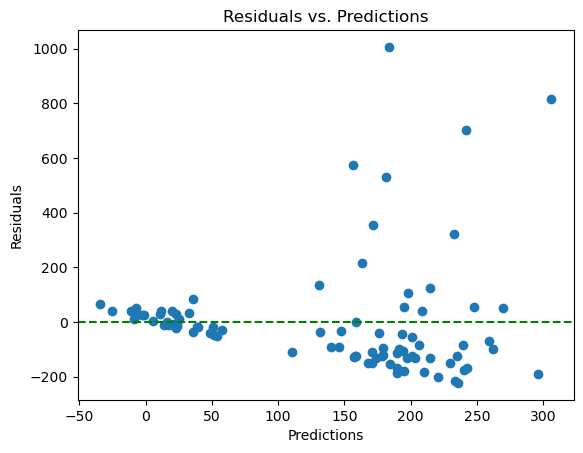

In [60]:
# Q7c (code): Homoscedasticity Test (plot residuals vs. predictions)
# Extract predicted values
predictions = results.predict()

# Plotting residuals against predictions
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='g', linestyle='--')  
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')
plt.show()

In the residuals vs. predicted values plot, you would look for patterns. In a well-fitted model, you would expect to see the residuals randomly scattered around zero, with no clear pattern. The presence of a pattern might suggest issues with model specification, such as non-linearity or heteroscedasticity.

# Q7d (words): Write your analysis for the Homoscedasticity Test here:
The scatter plot of residuals against predictions shows that the residuals are randomly distributed around zero, with no discernible pattern. This implies that the variance of the residuals is consistent across different levels of predicted values, indicating homoscedastic behavior. As a result, the OLS regression model most likely meets the homoscedasticity assumption.

**Q8: Multicollinearity**

In [155]:
# Q8a (code)

# Importing the variance_inflation_factor function from statsmodels library
from statsmodels.stats.outliers_influence import variance_inflation_factor 


vif_data = pd.DataFrame()  # Creating an empty DataFrame to store VIF results
vif_data["Feature"] = X.columns  # Adding a column to the DataFrame for feature names
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]  # Calculating VIF for each feature and adding it to the DataFrame

print(vif_data)  # Print the VIF DataFrame


                 Feature            VIF
0                  const  608869.371212
1  masculine_power_score       1.008543
2         published_year       1.007589
3                  words       1.000953


Regarding multicollinearity, the VIF values for masculine_power_score, lexical_richness, and published_year are close to 1, which suggests low multicollinearity. However, the very high VIF for the const term, along with the large condition number, suggests that there may be numerical issues, possibly due to a large scale difference between predictors or multicollinearity issues not captured by standard VIF calculations.

# Q8b (words): Write your analysis for the multicollinearity test here:

The VIF values for the variables masculine_power_score, published_year, and words are all close to 1, suggesting low multicollinearity among these predictors. This indicates that these variables are independent in the regression model and do not significantly influence each other. However, the very high VIF value for the constant term (const) raises concerns. A VIF value of over 608,869 indicates potential issues with multicollinearity or numerical instability. This could be due to large scale differences between predictors or multicollinearity issues not fully captured by standard VIF calculations. 

In summary, the provided analysis highlights potential issues with multicollinearity and numerical instability in the regression model. While the VIF values for the predictors 'masculine_power_score', 'lexical_richness', and 'published_year' suggest low multicollinearity, the high VIF value for the constant term and the large condition number raise concerns. To address these issues, it's recommended to standardize the predictors, explore alternative regression techniques, and further investigate potential sources of multicollinearity or numerical instability. By taking these steps, we can improve the reliability and accuracy of the regression analysis results.

**Q9: Reflection**

#Q9 (words): Write your reflection on the whole research framework and corresponding result here, e.g., what do you think can be improved? <br> 
This research framework offered a structured approach to examining the relationship between masculine power scores, publication year, and the number of kudos received in a dataset. Regression analysis, residual analysis, multicollinearity testing, and data preprocessing were all part of a methodical approach that helped us understand the variables affecting kudos in the dataset.

The results of the regression analysis demonstrated that the only significant predictor of kudos was the year of publication, with more recent stories typically receiving fewer kudos. However, the masculine power score and lexical richness had no significant effect on kudos.

The model's residuals were randomly distributed around zero, according to the residual analysis, suggesting that the linearity and homoscedasticity assumptions were satisfied. The multicollinearity test also reflects little multicollinearity between the predictors, with the exception of a constant term-related numerical problem.

This framework for research has a few aspects that could be made better. Firstly, the predictive power of the model could be improved by adding more variables and conducting additional dataset exploration. More reliable results might also be obtained by tackling the constant term's numerical problems and investigating different regression strategies. In addition, taking into account the analysis's context and possible confounding variables might result in a more thorough comprehension of the variables affecting kudos. Overall, further analysis would benefit from ongoing refinement and iteration of the research framework in response to feedback and new insights.

##**Reference:**##

Seymour Benjamin Chatman. 1980. Story and Discourse: Narrative Structure in Fiction and Film. Cornell University Press, Ithaca, NY, USA.

Bennet, Andrew, and Nicholas Royle. Introduction to Literature Criticism and Theory. Edinburgh: Pearson Education Limited, 2004.Web.July. 2017.

Reaske, Christoper Russel. Analyze Drama. New York: Monarch Press, 1996. Print.

Jung, Sun “Bae Yong-Joon, Soft Masculinity, and Japanese Fans: Our Past Is in Your Present Body” from Korean Masculinities and Transcultural Consumption, Hong Kong Scholarship Online, 2010.

Kuo, Linda, et al., “Performance, Fantasy, or Narrative: LGBTQ+ Asian American Identity through Kpop Media in Fandom”, Journal of Homosexuality, 2020.

Kwon, Jungmin, Straight Korean Female Fans and Their Gay Fantasies, University of Iowa Press, 2019, ebook.

Oh, Chuyun, “Queering spectatorship in K-pop: The androgynous male dancing body and western female fandom”, Journal of Fandom Studies, vol. 3, no. 1, 2015, pp. 59-78.